# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai

# 2. Import necessary dependencies and set environment variables

In [2]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY: ··········


# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

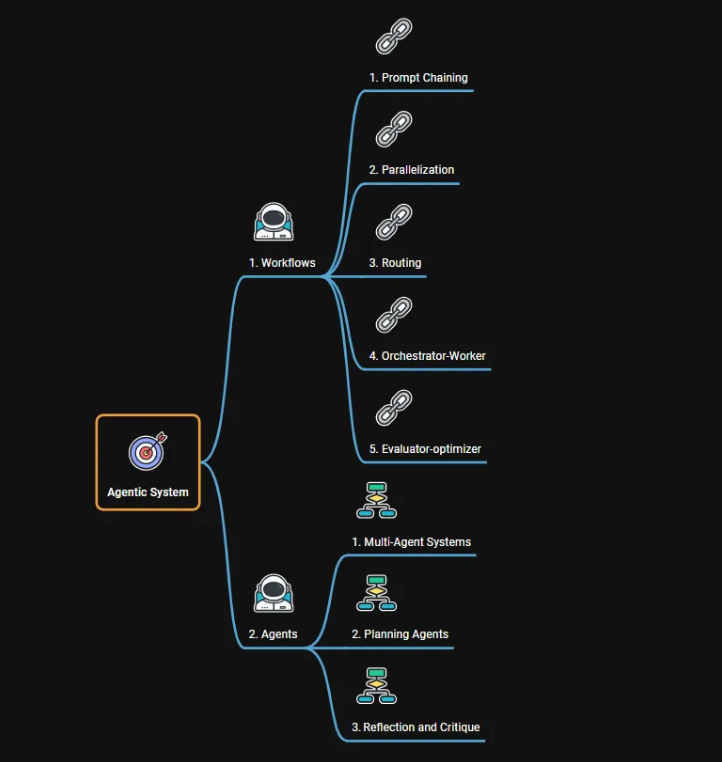

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Workflow - Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

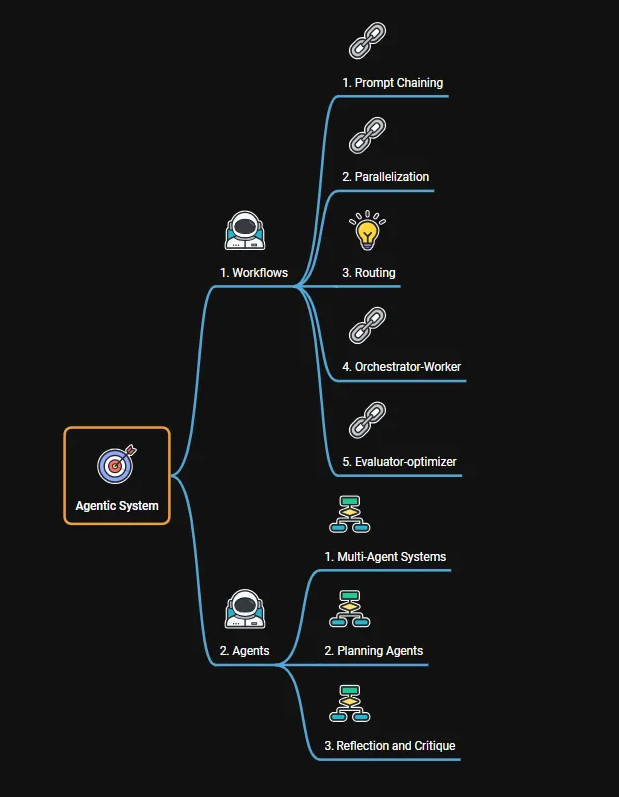

Detailed Blog : https://aiproductplaybook.substack.com/p/104-what-the-heck-are-workflow-routing

### a. Import LangGraph and other dependencies

In [51]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

### b. Defining a Schema for Structured Output and Augmenting the LLM with the Schema

In [52]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

### c. Defining a State Class

the input will be a user's question, the decision could be the dictionary option identified by the system, and the output could be the generated response.


In [53]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

### d. Defining Node Functions:

1. Node Functions:

a. llm_call_1(state: State):

This function is responsible for generating a story.
It takes the current state as input.
It uses an LLM (presumably through an llm.invoke() method) to generate a story based on the input provided in the state.
It returns a dictionary with the generated output (the story).

b. llm_call_2(state: State):

This function is responsible for generating a joke.
It follows the same structure as llm_call_1, using the LLM to generate a joke based on the input.

c. llm_call_3(state: State):

This function is responsible for generating a poem.
It also uses the LLM to generate an output based on the input, specifically a poem in this case.

d. llm_call_router(state: State):

This function acts as a router, deciding which of the three content generation functions (llm_call_1, llm_call_2, or llm_call_3) should be called next.
It uses the augmented LLM (router) with structured output to determine the next step.
It provides the LLM with a system message and the input from the current state.
The LLM is expected to generate a decision in the form of a Route object (as defined earlier), which contains the step field indicating the next action: "story", "joke", or "poem".
The function then returns a dictionary containing the decision.

2. Conditional Edge Function 🇰

This function takes the state as input, specifically looking at the decision field which was generated by the llm_call_router.

Based on the value of decision:

a. If decision is "story", it returns the name of the node llm_call_1.

b. If decision is "joke", it returns the name of the node llm_call_2.

c. If decision is "poem", it returns the name of the node llm_call_3.

This function essentially determines the next step in the workflow based on the LLM's decision.

In [54]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

### e. Build workflow

This code block defines a state graph that represents the workflow for routing the input to the appropriate content generation function. It includes nodes for each content generation function (llm_call_1, llm_call_2, llm_call_3) and a routing node (llm_call_router). The edges between these nodes are dynamically determined based on the output of the route_decision function.

In [55]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

### f. Visualize the workflow graph

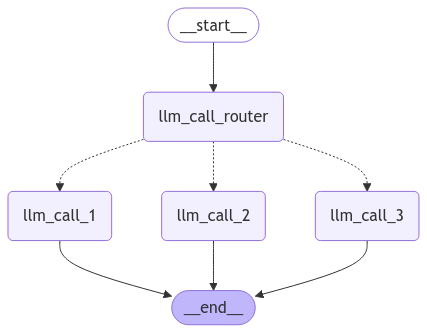

In [56]:
# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

### g. Invoke the Workflow - Routing

In [58]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about nerds"})
print(state["output"])

Why did the nerd bring a ladder to the bar?

Because he heard the drinks were on the house!


In [59]:
# Invoke
state = router_workflow.invoke({"input": "Write me a story about nerds"})
print(state["output"])

**The Quest for the Last Vintage Game**

In the heart of Blip City, where neon lights flickered to the rhythm of digital beats and retro arcades buzzed with the laughter of old-school gamers, lived four friends who were the quintessential nerds: Max, Zoe, Ravi, and Lena. Each of them had a unique passion: Max was an avid tabletop role-player, Zoe was a coding whiz, Ravi was a comic book expert, and Lena had a mastery of classic video games.

Their friendship blossomed during high school, where they spent many weekends in a dimly lit basement, surrounded by action figures and stacks of comic books. They played games that spanned generations and created legends of their own in the lands of imagination. But one crisp autumn afternoon, while rummaging through an old box of forgotten treasures at Max's house, they stumbled upon a dusty, faded flyer advertising the "Forgotten Legends Vintage Game Festival" happening that very weekend.

"One of the last bastions of classic gaming!" Max exclai

In [60]:
# Invoke
state = router_workflow.invoke({"input": "Write me a poem about nerds"})
print(state["output"])

In the realm where wisdom glows,  
Among the stacks where knowledge flows,  
A gathering of minds so bright,  
They dance with numbers, dreams take flight.  

With glasses perched upon their nose,  
In vintage tees, their passion shows,  
They venture forth on quests unknown,  
In pixelated worlds, their seeds are sown.  

They wield their laptops like a sword,  
In the code and lore, they’re never bored,  
From comic pages to starry skies,  
Their imaginations soar and rise.  

With every math problem they embrace,  
They find a beauty in every trace,  
In algorithms, they see the art,  
In every equation, they play their part.  

Conventions buzz with voices loud,  
Dungeons and dragons, they make us proud,  
They champion the tales of yore,  
In every heart, their spirits soar.  

So here’s to the nerds, both brave and wise,  
Who see the world with curious eyes,  
In their universe, there’s strength untold,  
In every story, their brilliance unfolds.  
